In [1]:
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV
import xlsxwriter
from random import randint
random_state = 7656
from preprocessing import stds, stats, cv_preprocessing
from load_data import load_data
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

average_precision_score = 0.5392805376958711
pr_auc = 0.5262875134822672


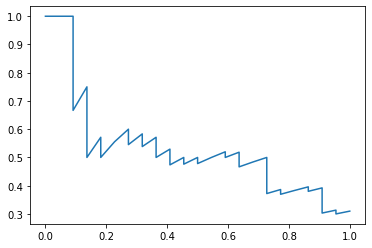

holdout i = q6.3_FLASH_target, roc_auc = 0.7987878787878787
average_precision_score = 0.2674379857468919
pr_auc = 0.25184673553184606


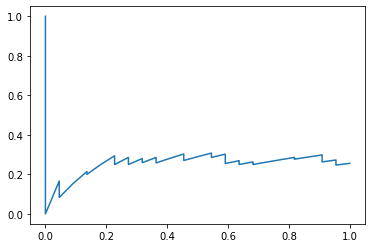

holdout i = q6.3_FLASH_target, roc_auc = 0.5927518427518428
average_precision_score = 0.34172548501152894
pr_auc = 0.34192022603896866


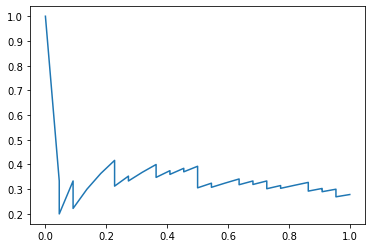

holdout i = q6.3_FLASH_target, roc_auc = 0.6824324324324325
average_precision_score = 0.42426689662602224
pr_auc = 0.4060258621875653


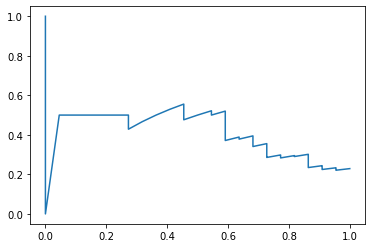

holdout i = q6.3_FLASH_target, roc_auc = 0.6987100737100737
average_precision_score = 0.38366815502233376
pr_auc = 0.3574095791630415


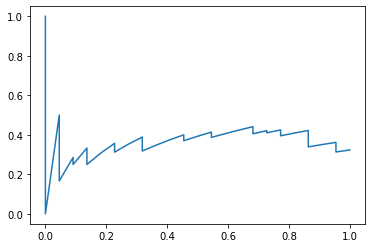

holdout i = q6.3_FLASH_target, roc_auc = 0.7512285012285012


In [10]:
df_preprocessed, features, target_feature = load_data()
#df_preprocessed = df_preprocessed[~df_preprocessed['phq3'].isna()]

secondary_targets = {
     'q6.1_INTRU_target':2,
 'q6.2_DREAM_target':2,
 'q6.3_FLASH_target':2,
 #'q6.4_UPSET_target':2,
 #'q6.5_PHYS_target':2,
#    'PCL_Strict3':0
}

secondary_targets2 = {
     'q6.1_INTRU_target':2,
 'q6.2_DREAM_target':2,
 'q6.3_FLASH_target':2,
 'q6.4_UPSET_target':2,
 'q6.5_PHYS_target':2,

    # 'target_avoidance':5,
 #'target_hyper':7,
  #  'phq3':13
}


X, X_out, Y, y_out = train_test_split(df_preprocessed[features + list(secondary_targets.keys())],\
                                      df_preprocessed['target_binary_intrusion'],\
                                          test_size=0.15, random_state=random_state,\
                                          stratify=df_preprocessed['target_binary_intrusion'])


cv = StratifiedKFold(5)

for train, test in cv.split(X, Y):
        
    x_train, y_train = X.iloc[train], Y.iloc[train]
    x_test, y_test = X.iloc[test], Y.iloc[test]

    y_train = []
   
    for k in secondary_targets.keys():
        y_train.append(x_train[k].apply(lambda x: int(x > secondary_targets[k])))
        
        
    x_train = x_train[features]
    x_test = x_test[features]
    
#     catboostmodel = CatBoostClassifier(verbose=0,  class_weights={0:40, 1:1})
#     catboostmodel.fit(x_train,y_train_cat, early_stopping_rounds=5)

#     cat_pred = catboostmodel.predict_proba(x_test)[:,1]
        
        
        
    x_train, x_test = cv_preprocessing(x_train, x_test)

    visible = Input(shape=(x_train.shape[1],))
   

    y = Dense(3, activation='relu')(visible)
    y = Dropout(0.1)(y)

#     x = Dense(3, activation='relu')(y)
#     x = Dropout(0.1)(x)
        
    outputs = []
        
        
    for i in secondary_targets.keys():
        outputs.append(Dense(1, activation='sigmoid')(y))
       
        
        
    model = Model(inputs=visible, outputs=outputs)
    model.compile(loss=['binary_crossentropy'] * 3,
              optimizer=Adam(), loss_weights =[1] * 3)
    
    model.fit(x_train, y_train , epochs = 350, class_weight=[{0:20,1:1}] * 3, verbose=0)
    
        # evaluate the model
    y_pred = model.predict(x_test)


    y_pred = np.hstack(y_pred).max(axis=1)

    
        
    precision, recall, _ = precision_recall_curve(y_test.astype(int), y_pred)
    avs = average_precision_score(y_test.astype(int), y_pred)
    print(f"average_precision_score = {avs}")

    auc_score = auc(recall, precision)
    print(f"pr_auc = {auc_score}")
    plt.plot(recall, precision)
    plt.show()
    print(f"holdout i = {i}, roc_auc = {roc_auc_score(y_test.astype(int), y_pred)}")

In [ ]:
avs = average_precision_score(y_test.astype(int), model.predict(x_test)[0])

In [ ]:
np.hstack(y_pred).shape

In [ ]:
cat_pred.shape

In [ ]:
target_feature

In [ ]:
np.vstack([cat_pred, np.hstack(y_pred).max(axis=1)]).max(axis=0).shape